## MNIST – Conv2D
 - compare the performance of convolutional neural networks vs fully connected networks.

### Create new dataset

In [1]:
import numpy as np # images are numpy arrays
# import tensorflow as tf # needed for the MNIST data set, not used this time!

from sklearn.datasets import fetch_openml # MNIST data
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, Activation, MaxPooling2D
# imports our layers we want to use

from tensorflow.python.keras.losses import categorical_crossentropy #loss function
from tensorflow.python.keras.optimizers import Adam, SGD #optimisers
from tensorflow.keras.utils import to_categorical #some function for data preparation

from tensorflow.compat.v1 import disable_eager_execution
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.optimizers import RMSprop

In [2]:
# MNIST Dataset was already used in Sheet 3, import dataset again, this time try method in sample solution
# all in sklearn

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(70000, 784) (70000,)
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
  18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
 253. 2

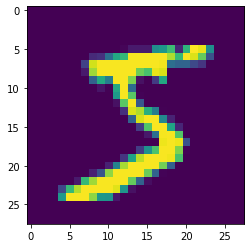

In [3]:
print(type(X), type(y))
print(np.shape(X), np.shape(y))

# print one example 
print(X[0])

plt.imshow(X[0].reshape(28,28))
plt.show()

# backround has to be simply zero

In [4]:
# reshape, place and reshape X
# how efficient is this actually

X_padded = np.zeros((70000,2500))
for i in range(70000):
    # reshape to square
    square = X[i].reshape(28,28)
    o = np.random.randint(22) #padding above, 50-28 = 22
    u = 22-o
    l = np.random.randint(22) #padding above, 50-28 = 22
    r = 22-l
    padded = np.pad(square, ((o,u), (l,r)), 'constant', constant_values=0)
    X_padded[i] = padded.reshape(2500,)

In [5]:
print(np.shape(X_padded))

(70000, 2500)


In [6]:
train_size = 60000
test_size = 10000

# divide into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, train_size=train_size, test_size=test_size)

# this rescales the images; does not change the shape, only values of entries
# scale data to have zero mean and unit variance [required by regressor]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # fit AND transform
X_test = scaler.transform(X_test)

print(np.shape(X_train))

(60000, 2500)


### Train simple dense neural network

In [7]:
# single hidden dense layer

batch_size = 128
num_classes = 10
epochs = 20

# convert class vectors to binary class matrices
# one-hot encode target column 
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(np.shape(y_test))

(10000, 10)


In [8]:
disable_eager_execution() # this had to be added to avoid error message

#Neural network with single dense hidden layer

model = Sequential()
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=SGD(), metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
# evaluate model
score = model.evaluate(X_test, y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 2s 158us/sample - loss: 2.9656 - accuracy: 0.0943

Test loss: 2.965608910751343
Test accuracy: 0.0943


It can be seen that the accuracy is very low.

### Improvement with convolutional neural network

I decided to test a network with two convolutional layers. 

In [10]:
# data preprocessing

# shape that our model expects is different from what we have so far
X_train = X_train.reshape(60000,50,50,1)
X_test = X_test.reshape(10000,50,50,1)

# first number: number of images (60,000 for X_train and 10,000 for X_test). 
# Then comes the shape of each image (28x28). 
# The last number is 1, which signifies that the images are greyscale.

In [11]:
# build model

# input shape is shape of one image, one single array
print(X_train.shape[1:])

model = Sequential()
# Sequential is the easiest way to build a model in Keras. 
# It allows you to build a model layer by layer.

# first layer 
# maybe try size 64 later
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
# 32 is output shape
model.add(Activation('relu'))
# Rectified Linear Activation. 
# This activation function has been proven to work well in neural networks.

# second layer
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(10, activation='softmax'))   

(50, 50, 1)


In [12]:
# training the model

# initiate RMSprop optimizer
opt = RMSprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy']) 

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 322s 5ms/sample - loss: 1.4581 - accuracy: 0.5058 - val_loss: 1.0273 - val_accuracy: 0.6752
Epoch 2/3
60000/60000 [==============================] - 364s 6ms/sample - loss: 0.8865 - accuracy: 0.7294 - val_loss: 0.8287 - val_accuracy: 0.7542
Epoch 3/3
60000/60000 [==============================] - 357s 6ms/sample - loss: 0.7138 - accuracy: 0.7959 - val_loss: 0.7105 - val_accuracy: 0.7946


In [13]:
# evaluate model
score = model.evaluate(X_test, y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 14s 1ms/sample - loss: 0.7105 - accuracy: 0.7946

Test loss: 0.7104521778106689
Test accuracy: 0.7946


Even with only 3 epochs the accuracy is improved about ten times compared to the normal dense layers.

### finetuning: Improve network performance 
The changes I tried were
- MaxPooling added as extra layer
- exchanged one convolutional layer to MaxPooling 
- adding two more convolutional layers --> deeper architecture
- dropout for both convolutional layers 

To compare the results just look at the accuracy of each of the trained network. 
Only a deeper architecture imporoves the result in my very simple natwork, but takes a lot longer. For the other changes I played around with the accuracy wasn't improved. Due to the long runtime I couldn't really investigate deeper networks or use a higher number of epochs. 

In [14]:
# Pooling, add one layer

# In "pool" of the 3x3 matrix of the convolution the highest value is selected
# same network as before but add pooling

# build model

# input shape is shape of one image, one single array
print(X_train.shape[1:])

model = Sequential()

# keep the first regular convolutional layer 
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

# add one pooling layer 
model.add(MaxPooling2D(pool_size =(3, 3), padding='same', strides=(1, 1)))
model.add(Activation('relu'))

# normal convolutional layer
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(10, activation='softmax'))

# training the model

# initiate RMSprop optimizer
opt = RMSprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy']) 

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

(50, 50, 1)
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 495s 8ms/sample - loss: 1.1670 - accuracy: 0.6264 - val_loss: 0.7668 - val_accuracy: 0.7739
Epoch 2/3
60000/60000 [==============================] - 484s 8ms/sample - loss: 0.6062 - accuracy: 0.8294 - val_loss: 0.5348 - val_accuracy: 0.8552
Epoch 3/3
60000/60000 [==============================] - 481s 8ms/sample - loss: 0.4502 - accuracy: 0.8780 - val_loss: 0.4325 - val_accuracy: 0.8870


In [82]:
# Pooling, replace one layer

# In "pool" of the 3x3 matrix of the convolution the highest value is selected
# same network as before but add pooling

# build model

# input shape is shape of one image, one single array
print(X_train.shape[1:])

model = Sequential()

# first layer 
model.add(MaxPooling2D(pool_size =(3, 3), padding='same', strides=(1, 1)))
# 32 is output shape
model.add(Activation('relu'))
# Rectified Linear Activation. 
# This activation function has been proven to work well in neural networks.

# second layer
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(10, activation='softmax'))

# training the model

# initiate RMSprop optimizer
opt = RMSprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy']) 

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

(50, 50, 1)
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 114s 2ms/sample - loss: 1.6913 - accuracy: 0.4393 - val_loss: 1.3612 - val_accuracy: 0.5967
Epoch 2/3
60000/60000 [==============================] - 108s 2ms/sample - loss: 1.1325 - accuracy: 0.6561 - val_loss: 1.0960 - val_accuracy: 0.6676
Epoch 3/3
60000/60000 [==============================] - 104s 2ms/sample - loss: 0.9535 - accuracy: 0.7136 - val_loss: 1.0008 - val_accuracy: 0.6941


In [83]:
### Trying a deeper architecture
# just add two more layers

# build model

# input shape is shape of one image, one single array
print(X_train.shape[1:])

model = Sequential()
# Sequential is the easiest way to build a model in Keras. 
# It allows you to build a model layer by layer.

# first layer 
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
# 32 is output shape
model.add(Activation('relu'))
# Rectified Linear Activation. 
# This activation function has been proven to work well in neural networks.

# second layer
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(10, activation='softmax'))   

# training the model

# initiate RMSprop optimizer
opt = RMSprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy']) 

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

(50, 50, 1)
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 791s 13ms/sample - loss: 1.1312 - accuracy: 0.6297 - val_loss: 0.6641 - val_accuracy: 0.8253
Epoch 2/3
60000/60000 [==============================] - 781s 13ms/sample - loss: 0.4906 - accuracy: 0.8663 - val_loss: 0.4180 - val_accuracy: 0.8851
Epoch 3/3
60000/60000 [==============================] - 828s 14ms/sample - loss: 0.3169 - accuracy: 0.9149 - val_loss: 0.2980 - val_accuracy: 0.9199


In [85]:
# dropout on convolutional layers

# deactivating certain individual nodes at random during training 
# we can simulate an ensemble of neural network with different architectures.

# build model

# input shape is shape of one image, one single array
print(X_train.shape[1:])

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(10, activation='softmax'))   

# training the model

# initiate RMSprop optimizer
opt = RMSprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy']) 

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

(50, 50, 1)
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 555s 9ms/sample - loss: 1.5550 - accuracy: 0.4602 - val_loss: 1.1659 - val_accuracy: 0.6058
Epoch 2/3
60000/60000 [==============================] - 570s 9ms/sample - loss: 0.9938 - accuracy: 0.6877 - val_loss: 0.9057 - val_accuracy: 0.7232
Epoch 3/3
60000/60000 [==============================] - 618s 10ms/sample - loss: 0.8071 - accuracy: 0.7620 - val_loss: 0.7636 - val_accuracy: 0.7768


In [84]:
# Pooling, replace one layer, no activations fct. after MaxPooling

# In "pool" of the 3x3 matrix of the convolution the highest value is selected
# same network as before but add pooling

# build model

# input shape is shape of one image, one single array
print(X_train.shape[1:])

model = Sequential()

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size =(3, 3), padding='same', strides=(1, 1)))
# does max pooling need no activation function???? Does it have to be in combination woth the Conv2
# or does the entire thing work just by using the MaxPooling2D fct

model.add(Flatten())
model.add(Dense(10, activation='softmax'))

# training the model

# initiate RMSprop optimizer
opt = RMSprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy']) 

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

(50, 50, 1)
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 488s 8ms/sample - loss: 1.1381 - accuracy: 0.6378 - val_loss: 0.7503 - val_accuracy: 0.7936
Epoch 2/3
60000/60000 [==============================] - 433s 7ms/sample - loss: 0.5734 - accuracy: 0.8399 - val_loss: 0.5442 - val_accuracy: 0.8604
Epoch 3/3
60000/60000 [==============================] - 462s 8ms/sample - loss: 0.4178 - accuracy: 0.8867 - val_loss: 0.4492 - val_accuracy: 0.8918
